##Transformer

### [Naval](http://twitter.com/naval) Tweet Generation using Transformer (base code)

#### Motivation
Transformers, introduced in 2018 by researchers at Google in their remarkable paper, "Attention is All You Need". I has chaged the landscape of NLP, particularly for it's multihead attention mechanism. It has been particularly exceptional in NLG tasks. I have tried applying transformer to generate tweets like Naval without any transfer learning.

##### Dataset Preparations Steps:
> Scrapped Twitter Data using `Twint`

> Cleaned the data. By Removing Special Characters, Images Link, Links, hashtags, mentions and replies. Keeping the Emojis and tweets.

##### Importing Libraries

In [ ]:
!pip install tensorflow-datasets==1.2.0
import tensorflow as tf
import tensorflow_datasets as tfds
import os

     |████████████████████████████████| 2.3MB 2.8MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


##### Downloading the dataset


In [ ]:
! gdown --id 1cciKCJCsu8Nqc4PKww6ummoQfBFZqvtQ #RAW Tweets
! gdown --id 1-CgbvSIFHdLJwvKqAIaqPMcX5djiBXxR #Cleaned Tweets

Downloading...
From: https://drive.google.com/uc?id=1cciKCJCsu8Nqc4PKww6ummoQfBFZqvtQ
To: /content/naval.csv
7.35MB [00:00, 64.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CgbvSIFHdLJwvKqAIaqPMcX5djiBXxR
To: /content/naval_c.csv
100% 261k/261k [00:00<00:00, 68.9MB/s]


In [ ]:
#before cleaning
naval_tweets_raw = pd.read_csv("/content/naval.csv")
naval_tweets_raw.head() 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1297435160393129984,1295925108989521920,1598167622000,2020-08-23,07:27:02,UTC,745273,naval,Naval,NaN,Doesn’t feel right to me.,"['omaribisa', 'fuentescca']",[],[],0,0,0,[],[],https://twitter.com/naval/status/1297435160393...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '745273', 'username': 'naval'}, {...",NaN,NaN,NaN,NaN
1,1297431567489359873,1297324812659040260,1598166765000,2020-08-23,07:12:45,UTC,745273,naval,Naval,NaN,Siddhartha is a fictional retelling of the enl...,['101_chirag'],[],[],0,0,0,[],[],https://twitter.com/naval/status/1297431567489...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '745273', 'username': 'naval'}, {...",NaN,NaN,NaN,NaN
2,1297430323337162753,1297430323337162753,1598166468000,2020-08-23,07:07:48,UTC,745273,naval,Naval,NaN,The overscheduled life is not worth living.,[],[],[],100,642,3732,[],[],https://twitter.com/naval/status/1297430323337...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '745273', 'username': 'naval'}]",NaN,NaN,NaN,NaN
3,1297317113581850624,1297263391032193024,1598139477000,2020-08-22,23:37:57,UTC,745273,naval,Naval,NaN,In theory it’s because there’s less allocation...,"['lpolovets', 'ganeumann']",[],[],1,0,13,[],[],https://twitter.com/naval/status/1297317113581...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '745273', 'username': 'naval'}, {...",NaN,NaN,NaN,NaN
4,1297301967950102534,1297263391032193024,1598135866000,2020-08-22,22:37:46,UTC,745273,naval,Naval,NaN,For follow ons to be so important you’d have t...,['ganeumann'],[],[],1,0,20,[],[],https://twitter.com/naval/status/1297301967950...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '745273', 'username': 'naval'}, {...",NaN,NaN,NaN,NaN


In [ ]:
#After Cleaning

naval = pd.read_csv("/content/naval_c.csv", encoding='utf-8')
#trn_df, val_df = train_test_split(df, test_size = 0.2)
naval.head()

,tweet
0,The overscheduled life is not worth living.
1,Hope is the belief that this moment isn’t good...
2,"When it comes to healing the mind, placebo eff..."
3,"How long until we create the perfect drug, tha..."
4,Time spent has nothing to do with job done.


In [ ]:
tweets = naval['tweet'].to_list()
tweets[:10]

['The overscheduled life is not worth living.',
 'Hope is the belief that this moment isn’t good enough.',
 'When it comes to healing the mind, placebo effects are completely valid.',
 'How long until we create the perfect drug, that has everyone addicted, all the time?',
 'Time spent has nothing to do with job done.',
 'If no one in this world had anything to offer you, how would you live your life?',
 'Your worldview is your world.',
 'Your company may not be in the software business, but eventually, a software company will be in your business.',
 'Good advice is embodied.',
 'The ability to stay calm during conflict is a superpower.']

#### Creating the Tokenizer

In [ ]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      tweets,
      target_vocab_size=100000
  )

In [ ]:

tokenizer.vocab_size

10260

Adding 2 tokens -> The start token and end token to our vocab thus our VOCAB_SIZE will have 2 added elements

##### Defining start and end tokens

In [ ]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

#Vocab size after adding start and end tokens
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
MAX_LENGTH = 100

def tokenize(sentence_list):
  
  ## Add start token and end token to the tokenized output of each sentence
  tokenized_sentence_list = [
    START_TOKEN + tokenizer.encode(sentence) + END_TOKEN \
    for sentence in sentence_list
  ]

  padded_list = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_sentence_list, maxlen = MAX_LENGTH, padding='post'
  )

  return padded_list

In [ ]:
tweets_tokenized = tokenize(tweets)

tweets_tokenized[0]

array([10260,    14,  5642,   220,     7,    30,   316,  6082, 10050,
       10261,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

#### Tokens list to Dataset

In [ ]:
def tokenslist_to_dataset(tokens_list, shuffle=True, batch_size=64):

  ## index in y
  dataset = tf.data.Dataset.from_tensor_slices(( 
          tokens_list[:, :-1],
          tokens_list[:, 1:]
  ))

  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(tokens_list))

  dataset = dataset.batch(batch_size)

  return dataset

In [ ]:
tweet_ds = tokenslist_to_dataset(tweets_tokenized)

In [ ]:
for batchX, batchY in tweet_ds:
  print(batchX[0], batchY[0])
  break

tf.Tensor(
[10260    69   724     7     6  3069  1176     3   356   806     4     9
    11  5362     4    25  2094     5  2333     3  2467  2094    33   724
    25  1210   713  3462     3  2467  7947    33   723    77     2   120
    15    75  8030 10050 10261     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0], shape=(99,), dtype=int32) tf.Tensor(
[   69   724     7     6  3069  1176     3   356   806     4     9    11
  5362     4    25  2094     5  2333     3  2467  2094    33   724    25
  1210   713  3462     3  2467  7947    33   723    77     2   120    15
    75  8030 10050 10261     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0 

#### Attention
Masked Self Attention
The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value).

In [ ]:
def masked_self_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output
  

#### Multi-head attention Layer
>Multi-head attention consists of four parts:

* Linear layers and split into heads.
* Masked Self attention.
* Concatenation of heads.
* Final linear layer.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]


    # linear layers

    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)


    # split heads

    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)


    # masked self attention

    scaled_attention = masked_self_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])


    # concatenation of heads

    concat_attention = tf.reshape(scaled_attention,

                                  (batch_size, -1, self.d_model))

    # final linear layer
    
    outputs = self.dense(concat_attention)

    return outputs

#### Building the Transformer
Masking: 
>Mask the padding token since the model shouldn't see it as input.

>Remember previous words and then focus on the future outcomes 

In [ ]:
## 0 is token with which keras as padded our tokens.
def get_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def get_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  padding_mask = get_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

#### Positional Encoding
To ensure retention of sequential characteristics even with absense of reccurence, convolution.

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

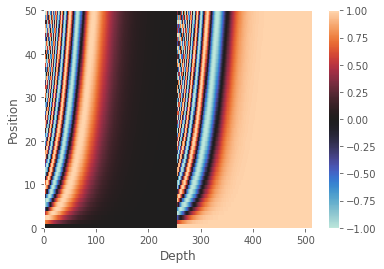

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='icefire')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### Decoder Layer
Each decoder layer consists of sublayers:

* Masked multi-head attention (with look ahead mask and padding mask)
* 2 dense layers followed by dropout

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)


  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

In [ ]:

sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

##### Decoder
The Decoder consists of:

* Output Embedding
* Positional Encoding
* N decoder layers 

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='Language_Decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs,  look_ahead_mask])

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

In [ ]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=8,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")


#### Transformer

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      get_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(inputs)
 

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, look_ahead_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

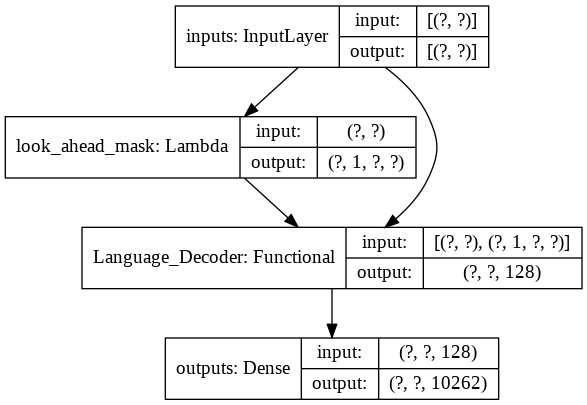

In [ ]:
sample_transformer = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=4,
    units=512,ac
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

#### Training

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 8
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

#### Loss function

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

##### Custom learning rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

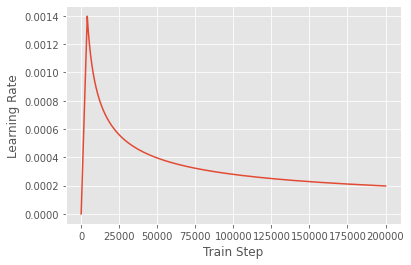

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### Compile Model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
Language_Decoder (Functional)   (None, None, 256)    6843904     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 10262)  2637334     Language_Decoder[0][0] 

In [ ]:
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 40

model.fit(tweet_ds, epochs=EPOCHS, callbacks = [checkpoint_callback])

Epoch 1/40
39/39 [==============================] - 6s 160ms/step - loss: 2.0668 - accuracy: 6.1667e-05
Epoch 2/40
39/39 [==============================] - 6s 159ms/step - loss: 2.0235 - accuracy: 0.0090
Epoch 3/40
39/39 [==============================] - 6s 160ms/step - loss: 1.9788 - accuracy: 0.0101
Epoch 4/40
39/39 [==============================] - 6s 159ms/step - loss: 1.9284 - accuracy: 0.0101
Epoch 5/40
39/39 [==============================] - 6s 159ms/step - loss: 1.8659 - accuracy: 0.0101
Epoch 6/40
39/39 [==============================] - 6s 160ms/step - loss: 1.7930 - accuracy: 0.0101
Epoch 7/40
39/39 [==============================] - 6s 159ms/step - loss: 1.7141 - accuracy: 0.0101
Epoch 8/40
39/39 [==============================] - 6s 160ms/step - loss: 1.6424 - accuracy: 0.0125
Epoch 9/40
39/39 [==============================] - 6s 158ms/step - loss: 1.5887 - accuracy: 0.0188
Epoch 10/40
39/39 [==============================] - 6s 159ms/step - loss: 1.5547 - accuracy: 0.

#### Testing the model

In [ ]:
def exploit_best_token_while_exploring(probabilites, exploration_len=5):
    ## Get the top k probabilites indices where k is exploration_len 
    top_indices = np.argpartition(probabilites, -exploration_len)\
                            [-exploration_len:]

    ## Getting top proabilities value
    top_probabilities = probabilites[top_indices]
    
    ## Normalizing it so that they sum is 1
    top_probabilities = top_probabilities / np.sum(top_probabilities)
    ## Although we choose next token randomly for our options we 
    ## pass the probabilities associated with each to account for the
    ## model's confidence for the token also. 
    choice = np.random.choice(exploration_len, 1, p = top_probabilities)

    ## Return next token id based on choice
    next_token_id = int(top_indices[choice][0])
    return next_token_id

In [ ]:

def tweet(sentence, MAX_LEN = 64):
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence), axis=0)
  

  for pos in range(MAX_LEN):
    predictions = model(sentence, training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[0, -1]
    softmax_logits = tf.nn.softmax(predictions, axis=0).numpy()

    ## Depending on whether we are in initial or final stages of the tweet
    ## we determine how many options we should explore to make sure we have
    ## variety in tweets generated
    if pos == 0:
      # If we are predicting first word we need maximum exploration
      exploration_len = 50

    elif pos < 4:
      # The next three words have exploration length 15
      exploration_len = 15

    else:
      # As we move further we narrow our exploration length
      exploration_len = 4

    predicted_id = exploit_best_token_while_exploring(softmax_logits, 
                                                         exploration_len)
    
    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]) or tf.equal(predicted_id, START_TOKEN[0]):
      return tokenizer.decode(tf.squeeze(sentence[:, 1:]).numpy())

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input in enxt iteration.
    sentence = tf.concat([sentence,tf.ones((1,1), dtype = tf.int32)*predicted_id], axis=-1)

  ## If we did not get end token it means no tweet is formed and we try again
  return tweet(sentence)

In [ ]:
tweet('We are')

"We are, with a age of people, and the first knowledge. The most of technology, and the mind. It's of you’re not just going to see what it can going from it."

In [ ]:
tweet("If humans can")

'If humans can’t be taught, then it to do it.'

In [ ]:
tweet("Technology")

'Technology.'

In [ ]:
tweet("Life")

'Life - I have the same level.'

#### Conclusion

A vanilla Transformer implementation on Tensorflow from scratch without using any Transfer Learning to generate text. With more data, deeper networks and longer training time, it is capable of achieving better results. For the same task, Huggingface's Transformer implementation provides much better performance and is easier to use. Also, coupled with variety of pre-trained models from GPT-2, T5, clearly outperforms this vanilla implementation. But, the goal here is to understand the working of Transformer model and then applying that to solve better problems, more efficiently.